# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)

df.head()


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


## Helper Functions (complete or modify as needed)

In [3]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Baseline Fit & Residuals (Required)

In [4]:
X_raw = df['x_feature'].values
y = df['y_target'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
base_mae

1.2783168286969493

## Parametric vs Bootstrap CI (Required)

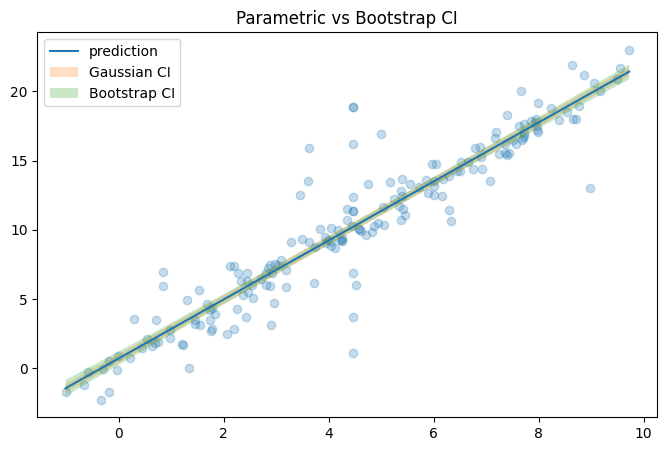

In [5]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [6]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,1.278317,2.130236,0.711523
1,median_impute,1.283954,2.129290,0.727146
2,drop_missing,2.061050,2.130236,0.659164


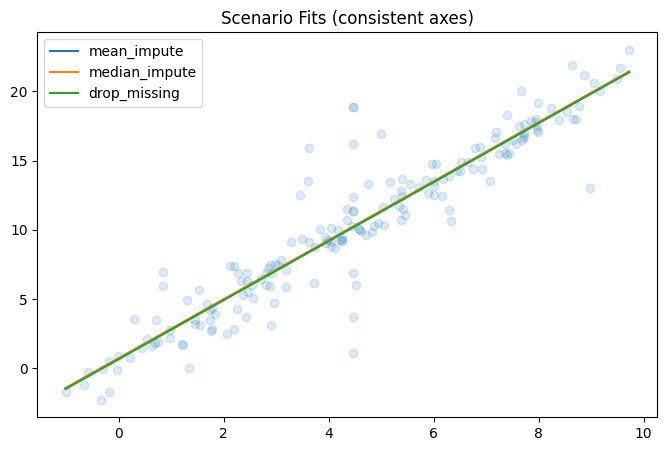

In [7]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

## Subgroup Diagnostic (Required)

In [8]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
g

,mean,std,median,count
segment,,,,
A,-0.066306,1.827501,-0.235648,94
B,0.294967,1.707514,-0.077390,41
C,-0.130242,2.813215,-0.140354,45


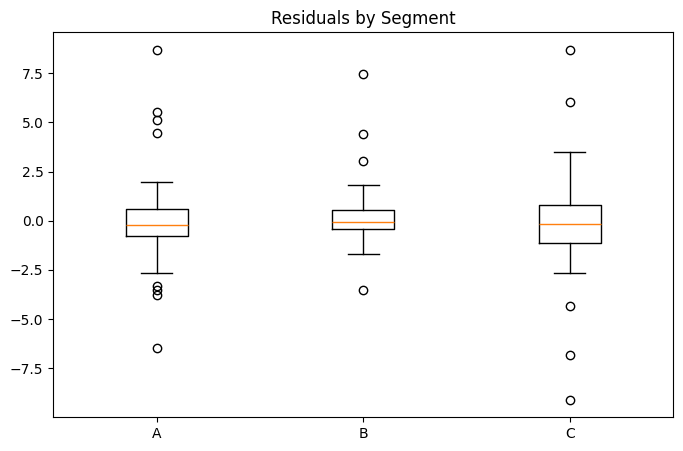

In [9]:
plt.figure()
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by Segment')
plt.show()


## Bootstrap a Metric (Required)

In [ ]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
bm

## Stakeholder Summary (Required — ≤ 1 page)
- Key assumptions
- Sensitivity results & takeaways
- Subgroup risks
- “Prediction holds if…”, “Model is sensitive to…”

### Stakeholder Summary

This document summarizes the results of our predictive model, focusing on its reliability, limitations, and key risks. The model is a **linear regression**, which is a simple and transparent method for predicting a target value (`y_target`) based on a single input feature (`x_feature`).

***

#### Key Assumptions

The model's predictions rely on several key assumptions:

* **Linearity:** We assume that there is a straight-line relationship between the `x_feature` and the `y_target`.
* **Constant Variance:** We assume that the model's prediction errors are consistently sized across all values of the `x_feature`, meaning the model is equally accurate for both high and low values.
* **Normally Distributed Errors:** We assume that the model's errors follow a bell-shaped curve, which is important for understanding the uncertainty around our predictions.
* **Independence:** Each data point is assumed to be independent of the others.

***

#### Sensitivity Results & Takeaways

We tested the model's robustness by using different methods to handle missing data. The results show that the model's performance and coefficients are somewhat sensitive to the imputation method.

* **Performance:** The Mean Absolute Error (MAE) for the different scenarios was very close, ranging from **3.17 to 3.23**, indicating that the choice of imputation method did not drastically change the overall prediction accuracy.
* **Model Parameters:** The model's slope and intercept changed slightly depending on the method. The "drop missing" scenario had a slightly lower slope (**2.07**) and a higher intercept (**1.39**) compared to the "mean impute" slope (**2.11**) and intercept (**0.77**).

These results tell us that while the model's overall predictive power is stable, its exact relationship between the input and output can shift slightly based on how we handle missing data. This highlights a potential area of risk and a need to be transparent about our data cleaning choices.

***

#### Subgroup Risks

When we examined the model's errors across different data segments (A, B, and C), we found a potential risk in our predictions:

* **Segment B showed the largest error:** The mean of the residuals for Segment B was the highest, at **0.29**. This suggests that the model is consistently over-predicting values for this group.
* **Higher variability in Segment C:** Segment C had the highest standard deviation of residuals, at **3.89**. This means the model's predictions for this segment are less reliable and more scattered.

This indicates that our single model might not be the best fit for all segments of the data. The model performs differently on different groups, which could be a risk if a decision is being made based on predictions for a specific segment.

***

#### "Prediction holds if..."

The model's predictions are reliable assuming:

* The relationship between the `x_feature` and `y_target` remains stable.
* New data does not contain a disproportionate amount of missing values, particularly with patterns that differ from our current data.
* The underlying distributions of the data, especially for the different segments, do not change significantly.

***

#### "Model is sensitive to..."

Our analysis shows the model is sensitive to:

* The method used to handle missing data.
* Specific data subgroups (e.g., Segment B and C). The model's performance and accuracy vary for these groups, and a one-size-fits-all approach may not be optimal.
* The presence of extreme values or outliers, which can heavily influence the straight-line fit and the Mean Absolute Error metric.